### Descrição - Modelo Serial Dependent (lags)

Utiliza todo o conjunto de dados ``train.csv`` para fazer a previsão daquele mês em diante. Utiliza as estratégias de previsão Multioutput, DirecRec e Direct.

Objetivo de criar um arquivo para **submeter no kaggle** e avaliar a performance.


### Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from random import sample
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from warnings import simplefilter
simplefilter("ignore")

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure",
       autolayout=True,
       figsize=(11, 7),
       titlesize=18,
       titleweight='bold',
      )
plt.rc("axes",
       labelweight="bold",
       labelsize="large",
       titleweight="bold",
       titlesize=16,
       titlepad=10,
      )
plot_params = dict(color="0.75",
                   style=".-",
                   markeredgecolor="0.25",
                   markerfacecolor="0.25",
                  )
%config InlineBackend.figure_format = 'retina'


### Load datasets

In [3]:
cols = ["cfips", "microbusiness_density", "active"]
train_df = pd.read_csv('./files/train.csv',
                      usecols=["first_day_of_month"] + cols,
                      parse_dates=['first_day_of_month'],
                      index_col='first_day_of_month',
                      ).to_period('D').reindex(columns=cols)

train_df.index.names = ['Month']
train_df = train_df.drop("active", axis=1)

print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 122265 entries, 2019-08-01 to 2022-10-01
Freq: D
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cfips                  122265 non-null  int64  
 1   microbusiness_density  122265 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.8 MB
None


,cfips,microbusiness_density
Month,,
2019-08-01,1001,3.007682
2019-09-01,1001,2.884870
2019-10-01,1001,3.055843
2019-11-01,1001,2.993233
2019-12-01,1001,2.993233


In [4]:
test_df = pd.read_csv('./files/test.csv')
samp_sub_df = pd.read_csv('./files/sample_submission.csv')
display(test_df.head())
display(samp_sub_df.head())


,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671


### Setting Forecast parameters

In [5]:
# number of lags to use in X_train
nlags = 4

# number of steps between forecast origin and forecast horizon
nlead_time = 1

# number of forecast values to predict
nsteps = 8


#### Pivoted dataframe

In [6]:
# make pivot, setting date by index and cfips in columns
train_pivoted = train_df.pivot_table(index='Month', columns='cfips', values='microbusiness_density')
train_pivoted.tail()

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
Month,,,,,,,,,,,,,,,,,,,,,
2022-06-01,3.346197,8.507496,1.191678,1.275998,1.773202,0.937421,1.983687,2.724583,1.468978,1.117345,...,1.713062,6.101229,3.212966,113.19935,7.739897,2.783238,25.652266,3.906035,3.126551,1.803249
2022-07-01,3.437971,8.573463,1.216926,1.326588,1.831783,0.950089,2.042414,2.782648,1.548280,1.141118,...,1.766595,6.191458,3.184532,114.09351,7.884691,2.836282,25.939260,3.981813,3.225807,1.803249
2022-08-01,3.423852,8.491150,1.196728,1.292861,1.836289,0.962757,2.107667,2.788231,1.521846,1.131609,...,1.766595,6.221535,3.156099,113.44169,7.779387,2.811320,26.085369,3.974924,3.209264,1.785395
2022-09-01,3.442677,8.341701,1.206827,1.315346,1.852060,0.975424,2.166395,2.809447,1.502964,1.131609,...,1.766595,6.178568,3.170316,128.26224,7.792550,2.811320,26.090586,3.995591,3.209264,1.785395
2022-10-01,3.463856,8.359798,1.232074,1.287240,1.831783,0.988092,2.185970,2.800514,1.442544,1.117345,...,1.713062,6.217238,3.212966,227.75665,7.792550,2.823801,26.273220,4.009369,3.126551,1.785395


In [7]:
# select the period for forecasting and drop on train set
# y_test = train_pivoted.iloc[-nsteps:, :]    Don't have y_test because we will forecast in the months 2022-11-01 to 2023-06-01
# train_pivoted = train_pivoted.drop(y_test.index, axis=0)
# y_test_period = y_test.index
# X_test_period = X_fore.index

# features lags to make forecast
X_fore = train_pivoted.iloc[-nlags:, :]

# set period to forecast
X_fore_period = pd.date_range(start="2022-11", end="2023-06", periods=None, freq="MS").to_period("D")
X_fore_period.name = "Month"


In [8]:
# y_test_period

In [9]:
X_fore_period

PeriodIndex(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
             '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01'],
            dtype='period[D]', name='Month')

In [10]:
# y_test

In [11]:
X_fore

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
Month,,,,,,,,,,,,,,,,,,,,,
2022-07-01,3.437971,8.573463,1.216926,1.326588,1.831783,0.950089,2.042414,2.782648,1.548280,1.141118,...,1.766595,6.191458,3.184532,114.09351,7.884691,2.836282,25.939260,3.981813,3.225807,1.803249
2022-08-01,3.423852,8.491150,1.196728,1.292861,1.836289,0.962757,2.107667,2.788231,1.521846,1.131609,...,1.766595,6.221535,3.156099,113.44169,7.779387,2.811320,26.085369,3.974924,3.209264,1.785395
2022-09-01,3.442677,8.341701,1.206827,1.315346,1.852060,0.975424,2.166395,2.809447,1.502964,1.131609,...,1.766595,6.178568,3.170316,128.26224,7.792550,2.811320,26.090586,3.995591,3.209264,1.785395
2022-10-01,3.463856,8.359798,1.232074,1.287240,1.831783,0.988092,2.185970,2.800514,1.442544,1.117345,...,1.713062,6.217238,3.212966,227.75665,7.792550,2.823801,26.273220,4.009369,3.126551,1.785395


### Prepare features & target series

In [12]:
# setup the feature dataframe with the corresponding lags and lead time
def make_lags(ts, nlags, lead_time):
    
    return pd.concat({f'y_lag_{lag}': ts.shift(lag) for lag in range(lead_time, nlags + lead_time)}, axis=1)


In [13]:
# Four weeks of lag features
y = train_pivoted.copy()
X = make_lags(y, nlags, nlead_time).fillna(0.0)
display(y.head())
X.head()

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
Month,,,,,,,,,,,,,,,,,,,,,
2019-08-01,3.007682,7.239156,1.073138,1.310777,1.544148,0.926372,0.674981,2.691544,1.486542,1.104277,...,1.150575,5.916088,4.062681,30.183279,6.115724,2.640386,26.433363,4.612016,2.603246,1.548594
2019-09-01,2.884870,7.290936,0.995794,1.305176,1.575892,0.998556,0.739265,2.703752,1.355156,1.089747,...,1.150575,5.894528,3.888567,31.712736,6.142085,2.858371,26.611856,4.338306,2.683593,1.530794
2019-10-01,3.055843,7.425439,1.160149,1.254761,1.546415,0.974495,0.713551,2.693764,1.355156,1.084903,...,1.150575,5.881592,3.903076,31.990431,6.181626,2.913635,26.736261,4.420419,2.635385,1.530794
2019-11-01,2.993233,7.426071,1.000628,1.254761,1.573625,1.022618,1.054256,2.739270,1.362664,1.084903,...,1.200600,5.954897,3.845038,32.776520,6.234348,3.008812,26.920164,4.372520,2.683593,1.601994
2019-12-01,2.993233,7.470274,1.000628,1.265965,1.555485,1.034649,1.054256,2.729281,1.343894,1.089747,...,1.200600,5.911776,3.845038,32.806427,6.273890,3.088637,26.903938,4.310935,2.635385,1.584194


y_lag_1                                                    \
cfips          1001      1003      1005      1007      1009      1011    
Month                                                                    
2019-08-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2019-09-01  3.007682  7.239156  1.073138  1.310777  1.544148  0.926372   
2019-10-01  2.884870  7.290936  0.995794  1.305176  1.575892  0.998556   
2019-11-01  3.055843  7.425439  1.160149  1.254761  1.546415  0.974495   
2019-12-01  2.993233  7.426071  1.000628  1.254761  1.573625  1.022618   

                                                    ...   y_lag_4            \
cfips          1013      1015      1017      1019   ...     56027     56029   
Month                                               ...                       
2019-08-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2019-09-01  0.674981  2.691544  1.486542  1.104277  ...  0.000000  0.000000   
2019-10-01  0.739265  2.703752  1.355156  1.089747  ...  0.000000  0.000000   
2019-11-01  0.713551  2.693764  1.355156  1.084903  ...  0.000000  0.000000   
2019-12-01  1.054256  2.739270  1.362664  1.084903  ...  1.150575  5.916088   

                                                                          \
cfips          56031      56033     56035     56037      56039     56041   
Month                                                                      
2019-08-01  0.000000   0.000000  0.000000  0.000000   0.000000  0.000000   
2019-09-01  0.000000   0.000000  0.000000  0.000000   0.000000  0.000000   
2019-10-01  0.000000   0.000000  0.000000  0.000000   0.000000  0.000000   
2019-11-01  0.000000   0.000000  0.000000  0.000000   0.000000  0.000000   
2019-12-01  4.062681  30.183279  6.115724  2.640386  26.433363  4.612016   

                                
cfips          56043     56045  
Month                           
2019-08-01  0.000000  0.000000  
2019-09-01  0.000000  0.000000  
2019-10-01  0.000000  0.000000  
2019-11-01  0.000000  0.000000  
2019-12-01  2.603246  1.548594  

[5 rows x 12540 columns]

In [14]:
# setup the dataframe with the corresponding shifs steps
def make_multistep_target(ts, nsteps):
    
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in range(nsteps)}, axis=1)


In [15]:
# Eight-week forecast
y = make_multistep_target(y, nsteps).dropna()
print("y multistep (forecast horizon): ")
display(y.tail())

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)
print("\ny align: ")
display(y.tail())
print("\nX align: ")
X.tail()

y multistep (forecast horizon): 


y_step_1                                                    \
cfips          1001      1003      1005      1007      1009      1011    
Month                                                                    
2021-11-01  3.200948  7.900597  1.151890  1.231665  1.733947  0.800493   
2021-12-01  3.286307  7.930010  1.151890  1.209271  1.752009  0.837438   
2022-01-01  3.296781  7.733397  1.186629  1.214165  1.752923  0.848746   
2022-02-01  3.334431  7.823300  1.206827  1.236650  1.777708  0.874082   
2022-03-01  3.336785  7.945311  1.196728  1.264755  1.797986  0.924753   

                                                    ...  y_step_8            \
cfips          1013      1015      1017      1019   ...     56027     56029   
Month                                               ...                       
2021-11-01  1.951473  2.683291  1.376199  1.219866  ...  1.713062  6.101229   
2021-12-01  1.918949  2.696674  1.402519  1.215026  ...  1.766595  6.191458   
2022-01-01  1.977162  2.701134  1.412333  1.193420  ...  1.766595  6.221535   
2022-02-01  1.944535  2.706717  1.438767  1.326550  ...  1.766595  6.178568   
2022-03-01  1.977162  2.717883  1.457649  1.217193  ...  1.713062  6.217238   

                                                                          \
cfips          56031      56033     56035     56037      56039     56041   
Month                                                                      
2021-11-01  3.212966  113.19935  7.739897  2.783238  25.652266  3.906035   
2021-12-01  3.184532  114.09351  7.884691  2.836282  25.939260  3.981813   
2022-01-01  3.156099  113.44169  7.779387  2.811320  26.085369  3.974924   
2022-02-01  3.170316  128.26224  7.792550  2.811320  26.090586  3.995591   
2022-03-01  3.212966  227.75665  7.792550  2.823801  26.273220  4.009369   

                                
cfips          56043     56045  
Month                           
2021-11-01  3.126551  1.803249  
2021-12-01  3.225807  1.803249  
2022-01-01  3.209264  1.785395  
2022-02-01  3.209264  1.785395  
2022-03-01  3.126551  1.785395  

[5 rows x 25080 columns]


y align: 


y_step_1                                                    \
cfips          1001      1003      1005      1007      1009      1011    
Month                                                                    
2021-11-01  3.200948  7.900597  1.151890  1.231665  1.733947  0.800493   
2021-12-01  3.286307  7.930010  1.151890  1.209271  1.752009  0.837438   
2022-01-01  3.296781  7.733397  1.186629  1.214165  1.752923  0.848746   
2022-02-01  3.334431  7.823300  1.206827  1.236650  1.777708  0.874082   
2022-03-01  3.336785  7.945311  1.196728  1.264755  1.797986  0.924753   

                                                    ...  y_step_8            \
cfips          1013      1015      1017      1019   ...     56027     56029   
Month                                               ...                       
2021-11-01  1.951473  2.683291  1.376199  1.219866  ...  1.713062  6.101229   
2021-12-01  1.918949  2.696674  1.402519  1.215026  ...  1.766595  6.191458   
2022-01-01  1.977162  2.701134  1.412333  1.193420  ...  1.766595  6.221535   
2022-02-01  1.944535  2.706717  1.438767  1.326550  ...  1.766595  6.178568   
2022-03-01  1.977162  2.717883  1.457649  1.217193  ...  1.713062  6.217238   

                                                                          \
cfips          56031      56033     56035     56037      56039     56041   
Month                                                                      
2021-11-01  3.212966  113.19935  7.739897  2.783238  25.652266  3.906035   
2021-12-01  3.184532  114.09351  7.884691  2.836282  25.939260  3.981813   
2022-01-01  3.156099  113.44169  7.779387  2.811320  26.085369  3.974924   
2022-02-01  3.170316  128.26224  7.792550  2.811320  26.090586  3.995591   
2022-03-01  3.212966  227.75665  7.792550  2.823801  26.273220  4.009369   

                                
cfips          56043     56045  
Month                           
2021-11-01  3.126551  1.803249  
2021-12-01  3.225807  1.803249  
2022-01-01  3.209264  1.785395  
2022-02-01  3.209264  1.785395  
2022-03-01  3.126551  1.785395  

[5 rows x 25080 columns]


X align: 


y_lag_1                                                    \
cfips          1001      1003      1005      1007      1009      1011    
Month                                                                    
2021-11-01  3.203320  7.832168  1.136930  1.186877  1.731690  0.775862   
2021-12-01  3.200948  7.900597  1.151890  1.231665  1.733947  0.800493   
2022-01-01  3.286307  7.930010  1.151890  1.209271  1.752009  0.837438   
2022-02-01  3.296781  7.733397  1.186629  1.214165  1.752923  0.848746   
2022-03-01  3.334431  7.823300  1.206827  1.236650  1.777708  0.874082   

                                                    ...   y_lag_4            \
cfips          1013      1015      1017      1019   ...     56027     56029   
Month                                               ...                       
2021-11-01  1.918949  2.688868  1.372438  1.200503  ...  1.740911  5.969827   
2021-12-01  1.951473  2.683291  1.376199  1.219866  ...  1.740911  5.974150   
2022-01-01  1.918949  2.696674  1.402519  1.215026  ...  1.740911  5.883370   
2022-02-01  1.977162  2.701134  1.412333  1.193420  ...  1.792115  5.939567   
2022-03-01  1.944535  2.706717  1.438767  1.326550  ...  1.792115  5.943890   

                                                                          \
cfips          56031      56033     56035     56037      56039     56041   
Month                                                                      
2021-11-01  3.399715  88.099052  7.631161  3.434040  25.602377  3.364125   
2021-12-01  3.413940  90.942459  7.631161  3.452806  25.719137  3.439956   
2022-01-01  3.371266  90.077621  7.684154  3.362107  25.517462  3.481318   
2022-02-01  3.399715  92.220726  7.710652  3.255770  25.628914  3.501999   
2022-03-01  3.328592  96.304420  7.750398  3.093138  25.666065  3.481318   

                                
cfips          56043     56045  
Month                           
2021-11-01  3.124483  1.652596  
2021-12-01  3.107952  1.670559  
2022-01-01  3.058357  1.688522  
2022-02-01  3.124483  1.670559  
2022-03-01  3.058357  1.760374  

[5 rows x 12540 columns]

### Cfips encoding

In [16]:
le = LabelEncoder()

X_train = X.stack("cfips").reset_index("cfips")   # wide to long
X_train["cfips"] = le.fit_transform(X_train["cfips"])

y_train = y.stack('cfips')  # wide to long

display(X_train)
display(y_train)

,cfips,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Month,,,,,
2019-08-01,0,0.000000,0.000000,0.000000,0.000000
2019-08-01,1,0.000000,0.000000,0.000000,0.000000
2019-08-01,2,0.000000,0.000000,0.000000,0.000000
2019-08-01,3,0.000000,0.000000,0.000000,0.000000
2019-08-01,4,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2022-03-01,3130,2.892446,2.926768,3.039970,3.093138
2022-03-01,3131,25.438322,25.532248,25.846514,25.666065
2022-03-01,3132,3.954258,3.754478,3.777747,3.481318


y_step_1   y_step_2   y_step_3   y_step_4   y_step_5  \
Month      cfips                                                          
2019-08-01 1001    3.007682   2.884870   3.055843   2.993233   2.993233   
           1003    7.239156   7.290936   7.425439   7.426071   7.470274   
           1005    1.073138   0.995794   1.160149   1.000628   1.000628   
           1007    1.310777   1.305176   1.254761   1.254761   1.265965   
           1009    1.544148   1.575892   1.546415   1.573625   1.555485   
...                     ...        ...        ...        ...        ...   
2022-03-01 56037   2.848763   2.851883   2.820681   2.783238   2.836282   
           56039  25.636610  25.626175  25.506157  25.652266  25.939260   
           56041   4.023147   4.064481   3.885368   3.906035   3.981813   
           56043   3.010753   2.977668   2.944582   3.126551   3.225807   
           56045   1.767542   1.767542   1.803249   1.803249   1.803249   

                   y_step_6   y_step_7   y_step_8  
Month      cfips                                   
2019-08-01 1001    2.969090   2.909326   2.933231  
           1003    7.413655   7.282522   7.309610  
           1005    1.027229   1.022314   1.032144  
           1007    1.253638   1.248041   1.264831  
           1009    1.573217   1.536999   1.541526  
...                     ...        ...        ...  
2022-03-01 56037   2.811320   2.811320   2.823801  
           56039  26.085369  26.090586  26.273220  
           56041   3.974924   3.995591   4.009369  
           56043   3.209264   3.209264   3.126551  
           56045   1.785395   1.785395   1.785395  

[100320 rows x 8 columns]

In [17]:
# reshapes the test dataframe to match training dataframe
def reshape_Xfore(df_train, df_test, encoder, fore_origin):
    df = pd.DataFrame(df_test.sort_index(ascending=False).values.T,
                      columns=df_train.columns[1:],
                      index=df_test.columns,
                     ).reset_index()

    # convert the index values to a date using the date string
    df.index = [fore_origin[0] for _ in range(len(df.index))]
    df.index.name = df_train.index.name
    
    df["cfips"] = encoder.transform(df["cfips"])
    
    return df

X_fore = reshape_Xfore(X_train, X_fore, le, X_fore_period)
# y_test = pd.DataFrame(y_test.stack("cfips"), columns=["microbusiness_density"])


In [18]:
X_fore

,cfips,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Month,,,,,
2022-11-01,0,3.463856,3.442677,3.423852,3.437971
2022-11-01,1,8.359798,8.341701,8.491150,8.573463
2022-11-01,2,1.232074,1.206827,1.196728,1.216926
2022-11-01,3,1.287240,1.315346,1.292861,1.326588
2022-11-01,4,1.831783,1.852060,1.836289,1.831783
...,...,...,...,...,...
2022-11-01,3130,2.823801,2.811320,2.811320,2.836282
2022-11-01,3131,26.273220,26.090586,26.085369,25.939260
2022-11-01,3132,4.009369,3.995591,3.974924,3.981813


In [19]:
# y_test

In [20]:
# reshapes the df_pred dataframe to match y_train
def reshape_ypred(df_test, df_pred, encoder, horizon_period):
    
    df_pred["cfips"] = encoder.inverse_transform(df_test["cfips"])
    df_pred = df_pred.set_index("cfips", append=True)
    df_pred.columns = horizon_period
    
    df_pred = pd.DataFrame(df_pred.reset_index("Month", drop=True).stack(),
                          columns=["microbusiness_density"],
                           )\
                          .reset_index("cfips")\
                          .pivot_table(index='Month', columns='cfips', values='microbusiness_density')\
                          .stack("cfips")

    df_pred = pd.DataFrame(df_pred, columns=["microbusiness_density"])    
        
    return df_pred


### SMAPE

In [21]:
# calculate SMAPE between forecasts and actual values
def smape(ts_true, ts_pred):
    
    y_true = ts_true.values.reshape(-1)
    y_pred = ts_pred.values.reshape(-1)
    numerator = 2 * np.abs(y_true - y_pred)
    denominator = np.abs(y_pred) + np.abs(y_true)
        
    df = pd.DataFrame(index=range(max(numerator.shape)), columns=["Numerator", "Denominator"])
    df["Numerator"] = numerator.T
    df["Denominator"] = denominator.T
    
    df = df[df["Denominator"] != 0.0]   # Drop rows where column "Denominator" is equal to 0

    return 100 * np.mean(df["Numerator"].values/df["Denominator"].values)


### Make submission file

In [22]:
def sub_file(sample_sub_df, df_pred):
    
    df_pred = df_pred.reset_index()
    df_pred["Month"] = df_pred["Month"].astype(str)
    df_pred["cfips"] = df_pred["cfips"].astype(str)
    df_pred["row_id"] = df_pred["cfips"] + "_" + df_pred["Month"]    
    df_pred = df_pred.drop(["Month", "cfips"], axis=1).reindex(columns=sample_sub_df.columns)
    
    sub_file_final = sample_sub_df.drop("microbusiness_density", axis=1).merge(df_pred, how="left", on="row_id")
    empty_values = sub_file_final.isna().sum().sum()
    
    return empty_values, sub_file_final


### Direct-Recursive Strategy & Model

In [23]:
# implements the direct-recursive forecast
model = RegressorChain(base_estimator=XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns)

y_pred = pd.DataFrame(model.predict(X_fore), index=X_fore.index, columns=y_train.columns).clip(0.0)
y_pred = reshape_ypred(X_fore, y_pred, le, X_fore_period)


In [24]:
emp_vals, sub_df = sub_file(samp_sub_df, y_pred)

# save submmission file
sub_df.to_csv('./submission_files/submission_DirecRec_serial.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)


Empty values in submission file:  0


In [25]:
y_fit

y_step_1   y_step_2   y_step_3   y_step_4   y_step_5  \
Month      cfips                                                          
2019-08-01 1001    2.893712   2.940910   2.914192   2.941869   2.977016   
           1003    5.972149   5.985696   5.996349   6.060076   6.039342   
           1005    1.607161   1.639537   1.648439   1.670474   1.659599   
           1007    1.607161   1.639537   1.648439   1.670474   1.659599   
           1009    1.607161   1.639537   1.648439   1.670474   1.659599   
...                     ...        ...        ...        ...        ...   
2022-03-01 56037   2.949030   2.945455   2.942339   2.961510   2.961893   
           56039  25.607664  25.607162  25.640741  25.662111  25.700254   
           56041   4.032585   4.058058   4.059113   4.062160   4.088841   
           56043   3.019943   3.009960   3.011727   3.017064   3.021432   
           56045   1.643958   1.671566   1.669701   1.664513   1.664924   

                   y_step_6   y_step_7   y_step_8  
Month      cfips                                   
2019-08-01 1001    2.983890   2.974266   3.026517  
           1003    6.005247   5.925276   6.699801  
           1005    1.659624   1.649380   1.672304  
           1007    1.659624   1.649380   1.672304  
           1009    1.659624   1.649380   1.672304  
...                     ...        ...        ...  
2022-03-01 56037   2.940555   2.942122   2.935229  
           56039  25.739651  25.613293  25.456476  
           56041   4.116668   4.109200   4.106964  
           56043   3.026949   3.030882   3.013132  
           56045   1.663299   1.670905   1.675031  

[100320 rows x 8 columns]

In [26]:
y_pred

microbusiness_density
Month      cfips                       
2022-11-01 1001                3.486844
           1003                8.147287
           1005                1.247582
           1007                1.281469
           1009                1.817124
...                                 ...
2023-06-01 56037               2.876331
           56039              25.607018
           56041               4.106964
           56043               3.127574
           56045               1.741692

[25080 rows x 1 columns]

Train SMAPE: 6.13



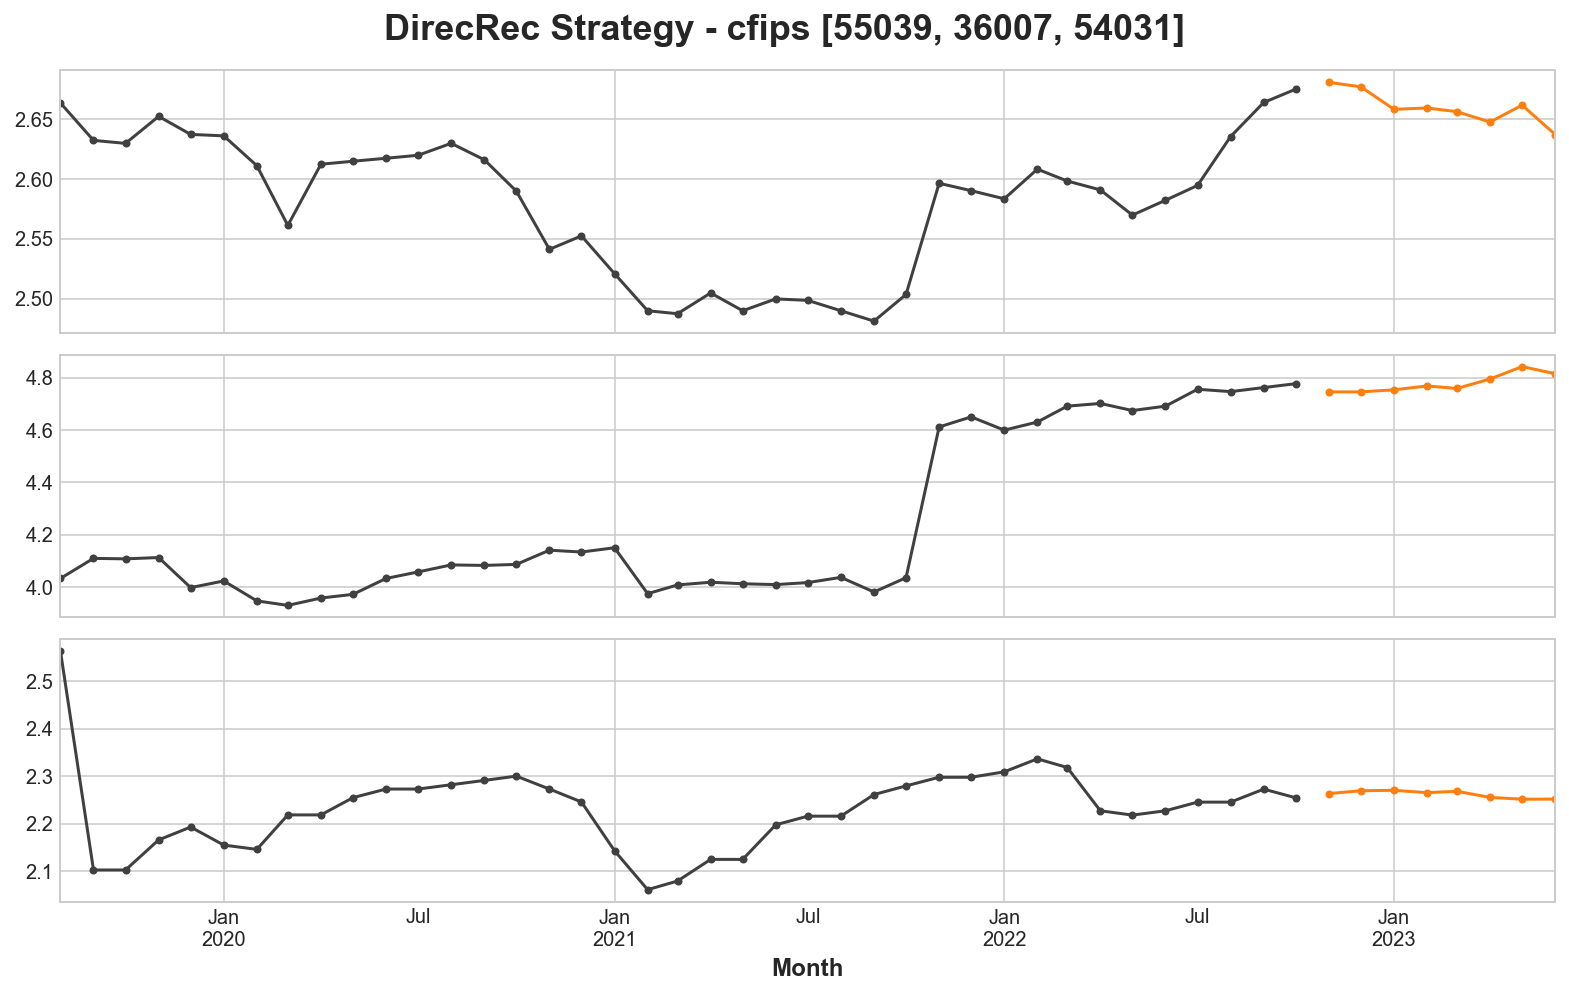

In [27]:
# Plot some prediction
train_smape = smape(y_train, y_fit)
# test_smape = smape(y_test, y_pred)
print(f"Train SMAPE: {train_smape:.2f}\n")

# Plot
cfips_ex = sample(list(train_pivoted.columns), 3)
# y_test_plot = y_test.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()
# y_fit_plot = y_fit.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()
y_pred_plot = y_pred.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()

axs = train_pivoted.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, style='.-')
# axs = y_test_plot.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_pred_plot.loc[:, cfips_ex].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
for ax in axs: ax.legend([])
_ = plt.suptitle(f"DirecRec Strategy - cfips {cfips_ex}")

### Direct strategy & model

In [28]:
# implements the direct strategy
model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns)

y_pred = pd.DataFrame(model.predict(X_fore), index=X_fore.index, columns=y_train.columns).clip(0.0)
y_pred = reshape_ypred(X_fore, y_pred, le, X_fore_period)


In [29]:
emp_vals, sub_df = sub_file(samp_sub_df, y_pred)

# save submmission file
sub_df.to_csv('./submission_files/submission_Direct_serial.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)


Empty values in submission file:  0


Train SMAPE: 6.13



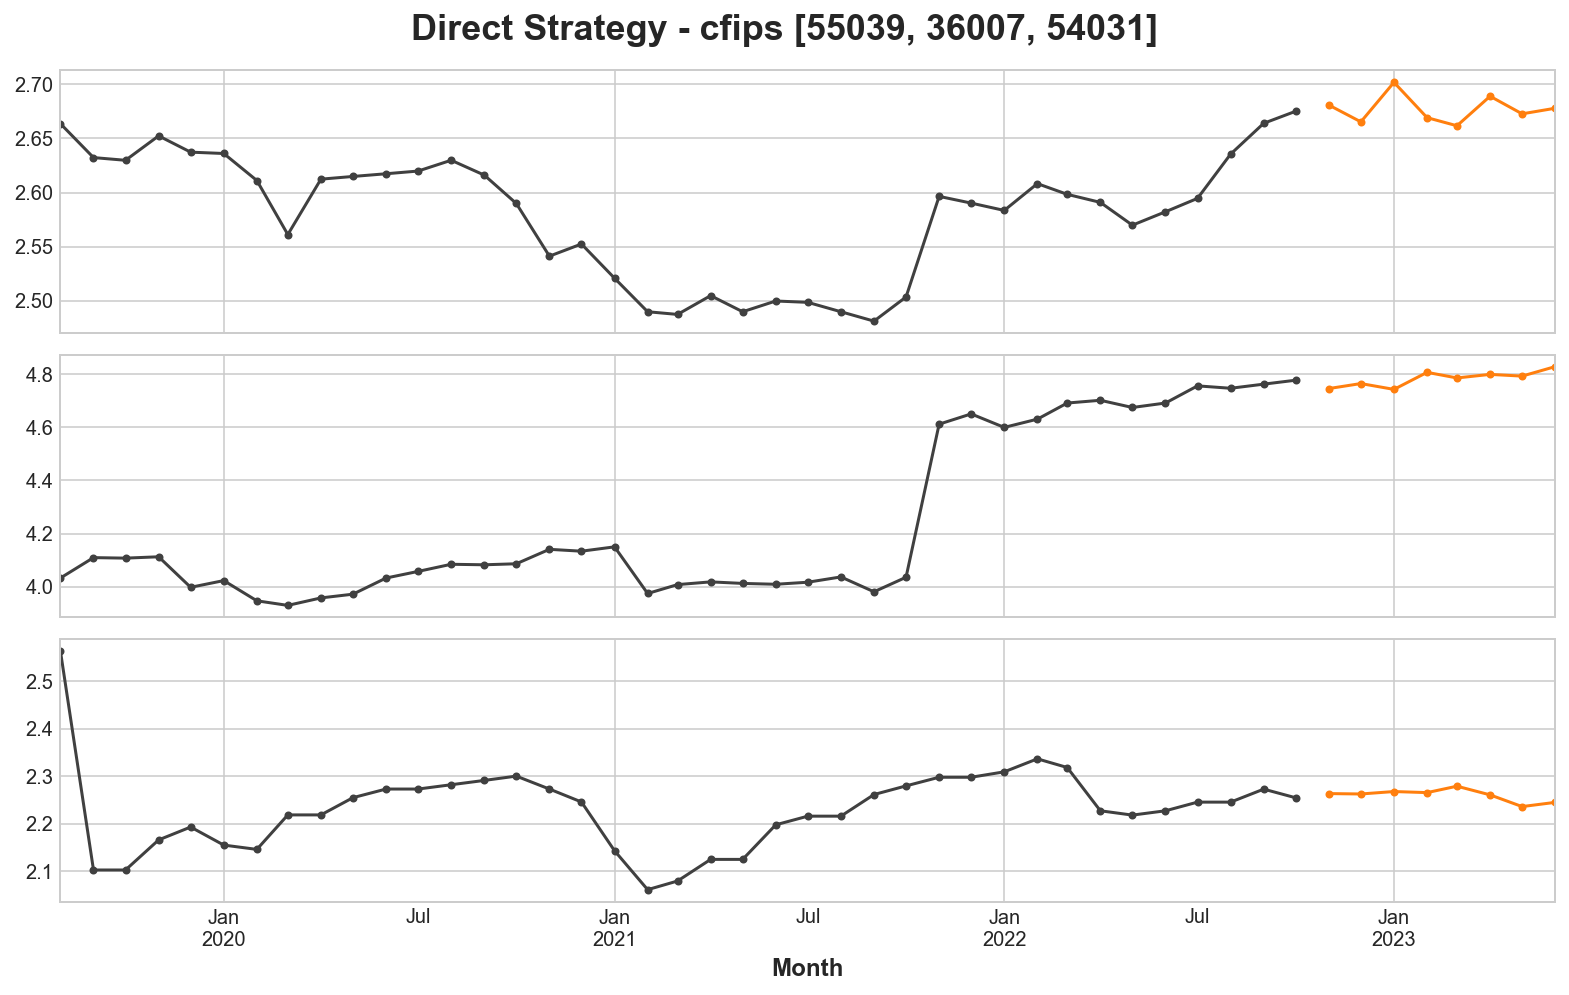

In [30]:
# Plot some prediction
train_smape = smape(y_train, y_fit)
# test_smape = smape(y_test, y_pred)
print(f"Train SMAPE: {train_smape:.2f}\n")

# Plot
# cfips_ex = sample(list(train_pivoted.columns), 3)
# y_test_plot = y_test.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()
# y_fit_plot = y_fit.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()
y_pred_plot = y_pred.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()

axs = train_pivoted.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, style='.-')
# axs = y_test_plot.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_pred_plot.loc[:, cfips_ex].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
for ax in axs: ax.legend([])
_ = plt.suptitle(f"Direct Strategy - cfips {cfips_ex}")

### Multioutput strategy & model

In [31]:
# Create splits
model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns)

y_pred = pd.DataFrame(model.predict(X_fore), index=X_fore.index, columns=y_train.columns).clip(0.0)
y_pred = reshape_ypred(X_fore, y_pred, le, X_fore_period)


In [32]:
emp_vals, sub_df = sub_file(samp_sub_df, y_pred)

# save submmission file
sub_df.to_csv('./submission_files/submission_Multioutput_serial.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)


Empty values in submission file:  0


Train SMAPE: 16.76



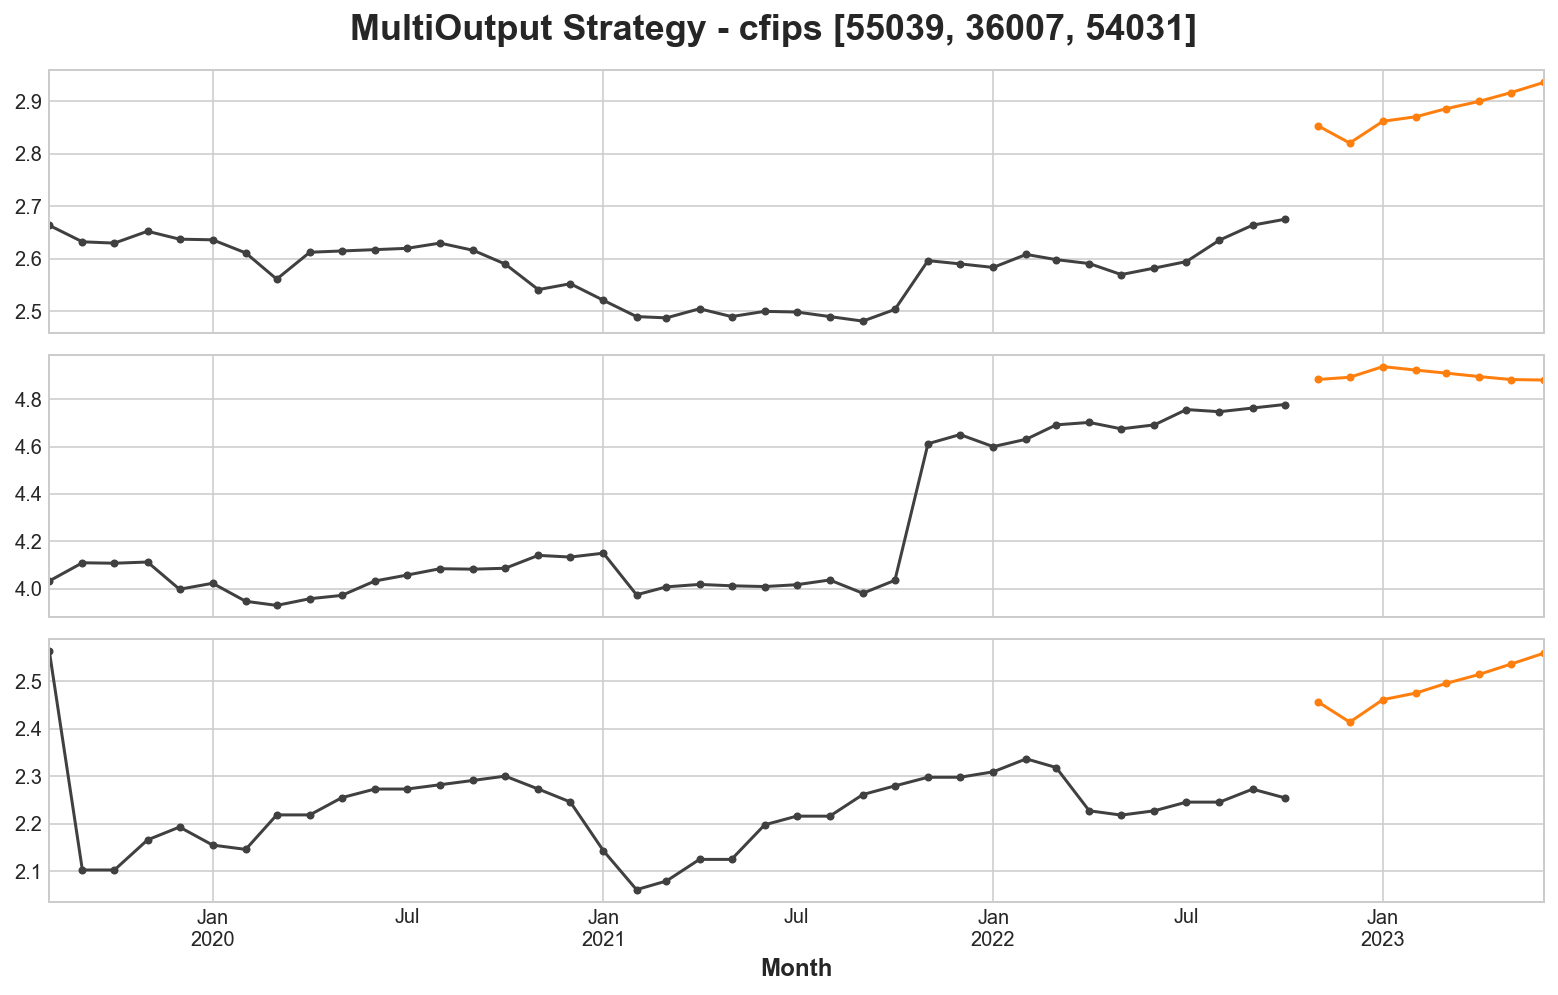

In [33]:
# Plot some prediction
train_smape = smape(y_train, y_fit)
# test_smape = smape(y_test, y_pred)
print(f"Train SMAPE: {train_smape:.2f}\n")

# Plot
# cfips_ex = sample(list(train_pivoted.columns), 3)
# y_test_plot = y_test.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()
# y_fit_plot = y_fit.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()
y_pred_plot = y_pred.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()

axs = train_pivoted.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, style='.-')
# axs = y_test_plot.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_pred_plot.loc[:, cfips_ex].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
for ax in axs: ax.legend([])
_ = plt.suptitle(f"MultiOutput Strategy - cfips {cfips_ex}")